# Data Source
* [Famine](https://web.archive.org/web/20170802193952/http://fletcher.tufts.edu/World-Peace-Foundation/Program/Research/Mass-Atrocities-Research-Program/Mass-Famine#Dataset)

# Data Preparation

In [1]:
# Get all necessary packages
import pandas as pd
import os
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read in and check file
famine = pd.read_csv("data" + os.sep + "famine" + os.sep + "famine.csv", sep = ",")
famine.head()

,Date Range,Start Year,End Year,Duration,Country,Cause,Range Death,Mean Death,Death per Year,Source
0,1870-71,1870,1871,NaN,Persia,"Economic crisis, drought","500,000-1.5 million",1000000,NaN,"Foran 1989, Okasaki 1986"
1,1876-1879,1876,1879,NaN,"China (Shanxi, Henan, Shandong, Zhili, and Sha...","Drought, lack of state capacity due to rebelli...",9m,9000000,NaN,"Edgerton-Tarpley, 2008; Fuller, 2015; Davis, 2..."
2,1870s,1870,1879,NaN,India,"Drought, colonialism",6m,6000000,NaN,"Davis, 2002"
3,1876-79,1876,1876,NaN,Brazil,"Drought, economic crisis",500000,500000,NaN,"Cunniff, 1970"
4,1885-99,1885,1899,NaN,Congo,"Colonialism, forced labor",3m,3000000,NaN,"Hochschild, 1998; Acherson 1999"


In [3]:
# Calculate duration 
# Add one to avoid duration of 0
famine["Duration"] = (famine["End Year"]+1) - famine["Start Year"]
famine.head()

,Date Range,Start Year,End Year,Duration,Country,Cause,Range Death,Mean Death,Death per Year,Source
0,1870-71,1870,1871,2,Persia,"Economic crisis, drought","500,000-1.5 million",1000000,NaN,"Foran 1989, Okasaki 1986"
1,1876-1879,1876,1879,4,"China (Shanxi, Henan, Shandong, Zhili, and Sha...","Drought, lack of state capacity due to rebelli...",9m,9000000,NaN,"Edgerton-Tarpley, 2008; Fuller, 2015; Davis, 2..."
2,1870s,1870,1879,10,India,"Drought, colonialism",6m,6000000,NaN,"Davis, 2002"
3,1876-79,1876,1876,1,Brazil,"Drought, economic crisis",500000,500000,NaN,"Cunniff, 1970"
4,1885-99,1885,1899,15,Congo,"Colonialism, forced labor",3m,3000000,NaN,"Hochschild, 1998; Acherson 1999"


In [4]:
# Calculate death per year
famine["Death per Year"] = famine["Mean Death"] / famine["Duration"]
famine.head()

,Date Range,Start Year,End Year,Duration,Country,Cause,Range Death,Mean Death,Death per Year,Source
0,1870-71,1870,1871,2,Persia,"Economic crisis, drought","500,000-1.5 million",1000000,500000.0,"Foran 1989, Okasaki 1986"
1,1876-1879,1876,1879,4,"China (Shanxi, Henan, Shandong, Zhili, and Sha...","Drought, lack of state capacity due to rebelli...",9m,9000000,2250000.0,"Edgerton-Tarpley, 2008; Fuller, 2015; Davis, 2..."
2,1870s,1870,1879,10,India,"Drought, colonialism",6m,6000000,600000.0,"Davis, 2002"
3,1876-79,1876,1876,1,Brazil,"Drought, economic crisis",500000,500000,500000.0,"Cunniff, 1970"
4,1885-99,1885,1899,15,Congo,"Colonialism, forced labor",3m,3000000,200000.0,"Hochschild, 1998; Acherson 1999"


Text(0.5, 0, 'Death per year')

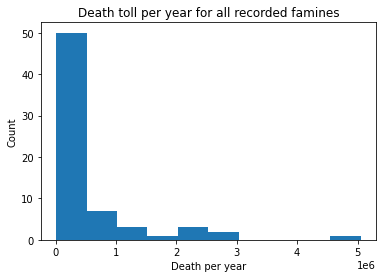

In [20]:
# Plot death per year
ax = famine["Death per Year"].sort_values(ascending=False).plot(kind="hist", bins= 10)
ax.set_title("Death toll per year for all recorded famines")
ax.set_ylabel("Count")
ax.set_xlabel("Death per year")

# Prepare for fitting

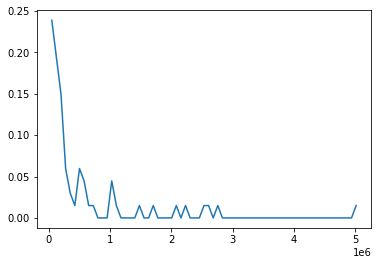

In [6]:
# Bin the data
density, death_per_year = np.histogram(famine["Death per Year"], bins = len(famine.index), density=True)
# adjust the denisty to the bin width (https://stackoverflow.com/questions/21532667/numpy-histogram-cumulative-density-does-not-sum-to-1)
density = density*np.diff(death_per_year)
# calculate the bin means
death_per_year = np.array([0.5 * (death_per_year[i] + death_per_year[i+1]) for i in range(len(death_per_year)-1)])
# plot
plt.plot(death_per_year, density)

# Fit to Power Law

In [7]:
# Fit data to power law
def powerlaw(x,exponent):
    return (x**exponent)/np.min(x)**exponent
params, covar = curve_fit(powerlaw, death_per_year, density)
params

array([-1.57879647])

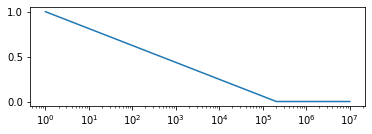

In [8]:
# Plot the power law
x_sim = np.linspace(1,10000000)
y_sim = powerlaw(x_sim, params[0])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim)
ax.set_xscale("log")

In [9]:
# Probability of death by famine
amount_dead = np.array([1,10,100,1000,10000,100000,1000000,10000000,100000000])
probs = powerlaw([amount_dead],params[0])
for i in range(len(amount_dead)):
    print("Dead: " + (str(amount_dead[i])))
    print("Prob of this many dead: " + str(probs[0][i]))

Dead: 1
Prob of this many dead: 1.0
Dead: 10
Prob of this many dead: 0.02637567197512913
Dead: 100
Prob of this many dead: 0.0006956760721396122
Dead: 1000
Prob of this many dead: 1.834892387970068e-05
Dead: 10000
Prob of this many dead: 4.839651973475989e-07
Dead: 100000
Prob of this many dead: 1.2764907292618904e-08
Dead: 1000000
Prob of this many dead: 3.366830075430499e-10
Dead: 10000000
Prob of this many dead: 8.880240566555412e-12
Dead: 100000000
Prob of this many dead: 2.342223122437004e-13


# Fit to lognormal

In [10]:
# Fit data to lognormal
def lognormal(x,upsilon,epsilon):
    numerator=np.exp(-np.power((np.log(x)-upsilon),2)/(2*epsilon**2))
    denominator=x*np.sqrt(2*np.pi*epsilon**2)
    return numerator/denominator
params, covar = curve_fit(lognormal, death_per_year, density)
params

array([1., 1.])

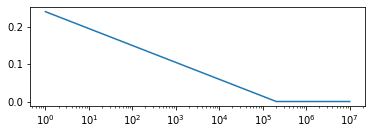

In [11]:
# Plot the lognormal
x_sim = np.linspace(1,10000000)
y_sim = lognormal(x_sim, params[0], params[1])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim)
ax.set_xscale("log")

In [12]:
# Probability of death by famine
amount_dead = np.array([1,10,100,1000,10000,100000,1000000,10000000,100000000])
probs = [lognormal(i,params[0], params[1]) for i in amount_dead]
for i in range(len(amount_dead)):
    print("Dead: " + (str(amount_dead[i])))
    print("Prob of this many dead: " + str(probs[i]))

Dead: 1
Prob of this many dead: 0.24197072451914337
Dead: 10
Prob of this many dead: 0.01707930831120357
Dead: 100
Prob of this many dead: 6.006101107306473e-06
Dead: 1000
Prob of this many dead: 1.0522765842835267e-11
Dead: 10000
Prob of this many dead: 9.185061761818969e-20
Dead: 100000
Prob of this many dead: 3.994378012615924e-30
Dead: 1000000
Prob of this many dead: 8.654284159840767e-43
Dead: 10000000
Prob of this many dead: 9.341745823045648e-58
Dead: 100000000
Prob of this many dead: 5.023886845089719e-75


# Recurence interval

In [22]:
# Bin the data
occurence, death_per_year = np.histogram(famine["Death per Year"], bins = 10)
# calculate the bin means
death_per_year = np.array([0.5 * (death_per_year[i] + death_per_year[i+1]) for i in range(len(death_per_year)-1)])
death_per_year

array([ 262475.,  766425., 1270375., 1774325., 2278275., 2782225.,
       3286175., 3790125., 4294075., 4798025.])

In [30]:
famine_recur = famine[["Death per Year", "Start Year"]]
famine_recur

,Death per Year,Start Year
0,5.000000e+05,1870
1,2.250000e+06,1876
2,6.000000e+05,1870
3,5.000000e+05,1876
4,2.000000e+05,1885
...,...,...
62,5.690000e+05,1998
63,5.000000e+04,1998
64,6.666667e+04,2003
65,2.500000e+04,2003


In [32]:
# Put it into categories to be able to calculate recurance rate
famine_recur["Death_binned"] = pd.cut(x=famine_recur["Death per Year"], bins=10)
famine_recur

/tmp/ipykernel_28297/1376980485.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  famine_recur["Death_binned"] = pd.cut(x=famine_recur["Death per Year"], bins=10)


,Death per Year,Start Year,Death_binned
0,5.000000e+05,1870,"(5460.5, 514450.0]"
1,2.250000e+06,1876,"(2026300.0, 2530250.0]"
2,6.000000e+05,1870,"(514450.0, 1018400.0]"
3,5.000000e+05,1876,"(5460.5, 514450.0]"
4,2.000000e+05,1885,"(5460.5, 514450.0]"
...,...,...,...
62,5.690000e+05,1998,"(514450.0, 1018400.0]"
63,5.000000e+04,1998,"(5460.5, 514450.0]"
64,6.666667e+04,2003,"(5460.5, 514450.0]"
65,2.500000e+04,2003,"(5460.5, 514450.0]"


In [37]:
# Sort it
famine_recur = famine_recur.sort_values("Start Year")
famine_recur

,Death per Year,Start Year,Death_binned
0,5.000000e+05,1870,"(5460.5, 514450.0]"
2,6.000000e+05,1870,"(514450.0, 1018400.0]"
1,2.250000e+06,1876,"(2026300.0, 2530250.0]"
3,5.000000e+05,1876,"(5460.5, 514450.0]"
4,2.000000e+05,1885,"(5460.5, 514450.0]"
...,...,...,...
62,5.690000e+05,1998,"(514450.0, 1018400.0]"
63,5.000000e+04,1998,"(5460.5, 514450.0]"
64,6.666667e+04,2003,"(5460.5, 514450.0]"
65,2.500000e+04,2003,"(5460.5, 514450.0]"


In [48]:
categories = famine_recur["Death_binned"].unique()
# for saving the dataframes
temp = []
#for cat in categories:
test= famine_recur.loc[famine_recur["Death_binned"] == categories[0],:]
#categories[0]
#famine_recur.iloc[0,2] == categories[0]
test["Start Year"].diff()

0      NaN
3      6.0
4      9.0
5      3.0
6      0.0
7      0.0
8      3.0
11     5.0
10     1.0
12     2.0
13     0.0
14     5.0
15     1.0
16     1.0
17     7.0
18     1.0
19     1.0
20     0.0
21     2.0
22     0.0
23     2.0
24     1.0
28    10.0
30     2.0
39     9.0
33     0.0
36     0.0
35     0.0
34     0.0
37     0.0
42     2.0
44     2.0
46    13.0
48     8.0
49     3.0
50     1.0
51     2.0
52     1.0
54     2.0
55     0.0
56     8.0
57     1.0
58     4.0
60     3.0
59     1.0
61     3.0
63     3.0
64     5.0
65     0.0
66     8.0
Name: Start Year, dtype: float64

In [65]:
famine_recur["Recurrence"]=famine_recur.groupby("Death_binned").diff(periods=1)["Start Year"]
famine_recur["Recurrence"][0] == pd.NA

<NA>

<AxesSubplot:>

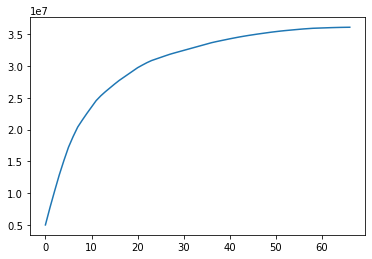

In [83]:
test = famine["Death per Year"].sort_values(ascending=False)
test.reset_index(drop=True, inplace=True)
test.cumsum().plot()

In [84]:
p = 1. * np.arange(len(test)) / (len(test)-1)
p
#https://stackoverflow.com/questions/24788200/calculate-the-cumulative-distribution-function-cdf-in-python

array([0.        , 0.01515152, 0.03030303, 0.04545455, 0.06060606,
       0.07575758, 0.09090909, 0.10606061, 0.12121212, 0.13636364,
       0.15151515, 0.16666667, 0.18181818, 0.1969697 , 0.21212121,
       0.22727273, 0.24242424, 0.25757576, 0.27272727, 0.28787879,
       0.3030303 , 0.31818182, 0.33333333, 0.34848485, 0.36363636,
       0.37878788, 0.39393939, 0.40909091, 0.42424242, 0.43939394,
       0.45454545, 0.46969697, 0.48484848, 0.5       , 0.51515152,
       0.53030303, 0.54545455, 0.56060606, 0.57575758, 0.59090909,
       0.60606061, 0.62121212, 0.63636364, 0.65151515, 0.66666667,
       0.68181818, 0.6969697 , 0.71212121, 0.72727273, 0.74242424,
       0.75757576, 0.77272727, 0.78787879, 0.8030303 , 0.81818182,
       0.83333333, 0.84848485, 0.86363636, 0.87878788, 0.89393939,
       0.90909091, 0.92424242, 0.93939394, 0.95454545, 0.96969697,
       0.98484848, 1.        ])

ValueError: x and y must have same first dimension, but have shapes (69, 3) and (67,)

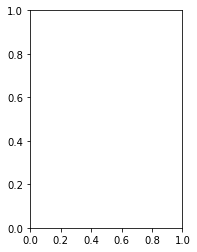

In [101]:
# plot the sorted data:
fig = plt.figure()

ax2 = fig.add_subplot(122)
ax2.plot(test, p)
ax2.set_xlabel('Death per Year')
ax2.set_ylabel('Proportion')
fig.tight_layout()

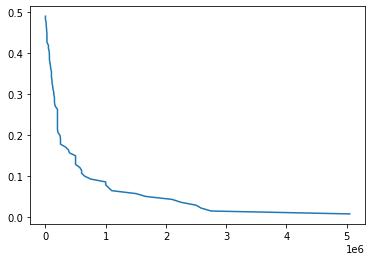

In [93]:
complete_timeline = 141
test = pd.DataFrame(test)
test["time"] = 1/complete_timeline
test["cs_time"] = np.cumsum(test["time"])
plt.plot(test["Death per Year"], test["cs_time"])

In [103]:
# Fit data to power law
def powerlaw(x,exponent):
    return (x**exponent)/np.min(x)**exponent
params, covar = curve_fit(powerlaw, test["Death per Year"], test["cs_time"])
params


array([-0.08216459])

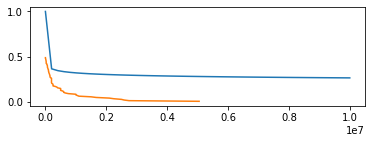

In [108]:
# Plot the power law
x_sim = np.linspace(1,10000000)
y_sim = powerlaw(x_sim, params[0])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim, label="sim")
ax.plot(test["Death per Year"], test["cs_time"], label="real")
#ax.set_xscale("log")

In [105]:
# Probability of death by famine
amount_dead = np.array([1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])
probs = powerlaw([amount_dead],params[0])
for i in range(len(amount_dead)):
    print("Dead: " + (str(amount_dead[i])))
    print("Prob of this many dead: " + str(probs[0][i]))

Dead: 1
Prob of this many dead: 1.0
Dead: 10
Prob of this many dead: 0.8276284513352935
Dead: 100
Prob of this many dead: 0.6849688534596562
Dead: 1000
Prob of this many dead: 0.5668997114017268
Dead: 10000
Prob of this many dead: 0.46918233020983596
Dead: 100000
Prob of this many dead: 0.3883086453454508
Dead: 1000000
Prob of this many dead: 0.32137528278736116
Dead: 10000000
Prob of this many dead: 0.2659793275907457
Dead: 100000000
Prob of this many dead: 0.22013205898113156
Dead: 1000000000
Prob of this many dead: 0.18218755506380338
